## Imports

In [1]:
import numpy as np
import torch

## Configuration

In [2]:
from omegaconf import OmegaConf

CONFIG = OmegaConf.create({
    # Dataset
    "num_classes": 10,
    "valid_transform_reprs": ["ToTensor()"],

    # Mean and std for normalization
    "normalize_mean": [0.4914, 0.4822, 0.4465],
    "normalize_std": [0.2023, 0.1994, 0.2010],

    # DataLoader
    "batch_size": 128,
    "num_workers": 8,
    "enable_pin_memory": True,

    # Model
    "model": "WideResNet-28-10-torchdistill",
    "dropout_rate": 0.3,

    # BN
    "noise_bn_option": "DARBN",

    # Checkpoint
    "checkpoint_filename": "simclr-drs__epoch_199.pt",
})

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Download checkpoint

In [4]:
import os
import gdown
from storage import CHECKPOINT_URLS

checkpoint_filepath = f"checkpoints/{CONFIG.checkpoint_filename}"
if not os.path.exists(checkpoint_filepath):
    gdown.download(CHECKPOINT_URLS[CONFIG.checkpoint_filename], checkpoint_filepath, quiet=False)

## Set Random Seed

In [5]:
np.random.seed(0)
torch.manual_seed(0)
# torch.use_deterministic_algorithms(True)

## Initialize Model

In [6]:
from initializers import initialize_model, InputNormalize
from models.noise_bn_option import NoiseBnOption

net = initialize_model(
    model_name=CONFIG.model, 
    num_classes=CONFIG.num_classes, 
    noise_bn_option=NoiseBnOption[CONFIG.noise_bn_option],
    dropout_rate=CONFIG.dropout_rate)
net = net.to(device)

normalizer = InputNormalize(
    torch.Tensor(CONFIG.normalize_mean).to(device), 
    torch.Tensor(CONFIG.normalize_std).to(device)
).to(device)

In [7]:
from checkpointing import load_checkpoint

load_checkpoint(net, optimizer=None, checkpoint_filepath=checkpoint_filepath)

In [8]:
net = net.eval()

## Load Dataset

In [9]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, CIFAR100
from initializers import initialize_transforms

DATA_ROOT = "./data"
valid_transform = initialize_transforms(CONFIG.valid_transform_reprs)
valid_dataset = CIFAR10(root=DATA_ROOT, train=False, transform=valid_transform, download=True)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=CONFIG.batch_size,
    num_workers=CONFIG.num_workers,
    pin_memory=CONFIG.enable_pin_memory,
)

Files already downloaded and verified


## Collect Outputs and Labels

In [10]:
# Get all the data
valid_outputs = []
valid_labels = []
for minibatch_i, (inputs, labels) in enumerate(valid_loader):
    inputs = inputs.float().to(device)

    with torch.no_grad():
        inputs = normalizer(inputs)
        labels = labels.to(device)
        outputs = net(inputs)

    valid_outputs.extend(outputs.cpu().detach().tolist())
    valid_labels.extend(labels.cpu().detach().tolist())

valid_outputs = np.array(valid_outputs)
valid_labels = np.array(valid_labels)
valid_preds = np.argmax(valid_outputs, axis=1)

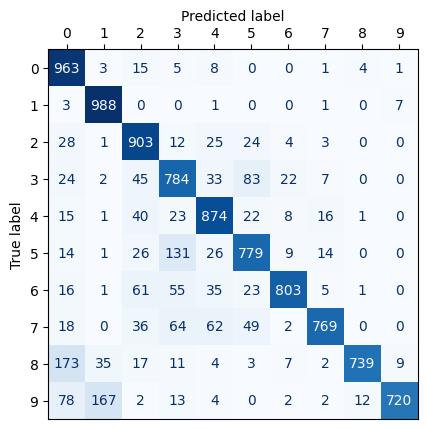

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots()
cmp = ConfusionMatrixDisplay.from_predictions(y_true=valid_labels, y_pred=valid_preds, ax=ax, colorbar=False, cmap=plt.cm.Blues)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
# ax.set_title(f"Confusion Matrix")
fig.savefig(f"confusion_matrix_{CONFIG.checkpoint_filename}.png", bbox_inches="tight")
fig.show()